In [1]:
%load_ext cython
import pyrost as rst
import speckle_tracking as st
# import pyfftw
from pyrost.bin import *
from pyrost import simulation as st_sim
import h5py
import os
import numpy as np
import pickle
import pyximport
import sys
import configparser
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from multiprocessing import cpu_count
from importlib import reload

pyximport.install(reload_support=True, build_in_temp=False,
                  build_dir='.pyxbld')

(None, <pyximport.pyximport.PyxImporter at 0x2b7cbc594750>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'gf', 'ggm', 'init_fftw', 'make_whitefield', 'np', 'pixel_translations', 'st', 'st_update']


In [3]:
import re

cxi_prt = rst.cxi_protocol(default_paths={'data': 'entry/instrument/detector/data',
                                          'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
                                          'y_pixel_size': 'entry/instrument/detector/y_pixel_size'})
log_prt = rst.log_protocol()
cxi_loader = rst.cxi_loader(cxi_prt)
scan_name = 2934
log_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/scan-logs/Scan_{scan_name:d}.log'
dir_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/scan-frames/Scan_{scan_name:d}'
paths = [os.path.join(dir_path, path) for path in os.listdir(dir_path)
         if path.endswith('Lambda.nxs')]
paths = sorted(paths, key=lambda path: int(re.search('\d*(?=_Lambda)', path)[0]))
data = cxi_loader.load_data(paths)
attrs = cxi_loader.load_attributes(paths[0])
log_attrs = log_prt.load_attributes(log_path)

In [4]:
translations = np.tile([[log_attrs['x_sample'], log_attrs['y_sample'], log_attrs['z_sample']]],
                       (log_attrs['n_steps'], 1)) * 1e-9
if log_attrs['scan_type'] == 'X-SAM':
    translations[:, 0] = log_prt.load_data(log_path) * 1e-9
elif log_attrs['scan_type'] == 'Y-SAM':
    translations[:, 1] = log_prt.load_data(log_path) * 1e-9

In [8]:
fs_vec = np.array([0, -1, 0], dtype=cxi_prt.get_dtype('basis_vectors'))
ss_vec = np.array([1, 0, 0], dtype=cxi_prt.get_dtype('basis_vectors'))
pix_vec = np.array([attrs['x_pixel_size'], attrs['y_pixel_size'], 0])
pix_vec

array([55., 55.,  0.])

In [ ]:
cxi_prt = rst.cxi_protocol(default_paths={'data': 'entry/data',
                                          'distance': 'entry/instrument/detector/detector_distance',
                                          'wavelength': 'entry/instrument/beam/incident_wavelength',
                                          'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
                                          'y_pixel_size': 'entry/instrument/detector/y_pixel_size'})
cxi_loader = rst.cxi_loader(cxi_prt)
cxi_loader.load('/gpfs/cfel/cxi/scratch/user/jdressel/0001626_master.h5')

In [250]:
with h5py.File('/gpfs/cfel/cxi/scratch/user/jdressel/0001626_master.h5', 'r') as cxi_file:
    print(cxi_file['entry/instrument/detector/geometry/orientation'].keys())

<KeysViewHDF5 []>


In [23]:
path = '/gpfs/cfel/cxi/scratch/user/litang/Detector_data_origin_angle0'\
       '_ab_tilt000_t85_p10_xyshift1um_silicon_sigenhance.cxi'
loader = rst.cxi_loader()
data = loader.load(path)
data.basis_vectors[:, 1] = -data.basis_vectors[:, 1]

In [175]:
data = data.update_defocus(defocus_fs=7.4e-5, defocus_ss=6e-5)
st_obj = data.get_st().update_reference(ls_ri=.5)

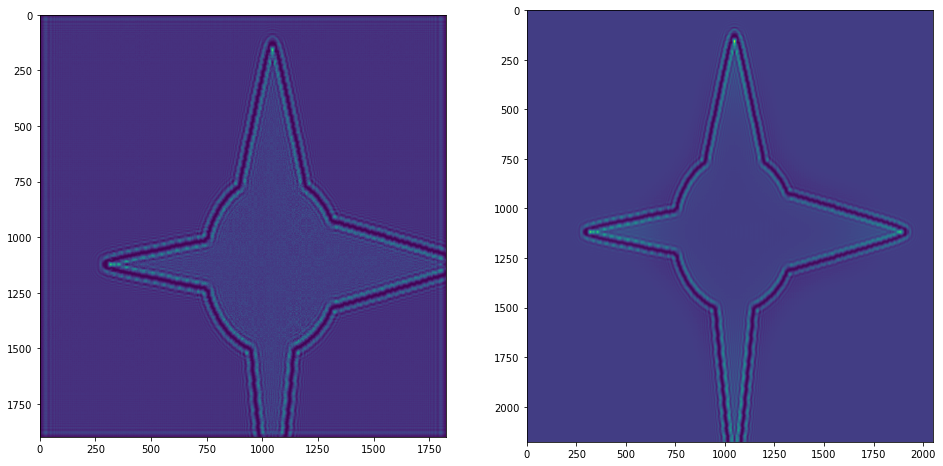

In [176]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(st_obj.data[0])
axes[1].imshow(st_obj.reference_image)
plt.show()

# ST Simulation

In [3]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                           bulk_atn=0.15, p0 = 5e4, th_s=8e-5, n_frames=200,
                           offset=2.0, step_size=0.1, focus=1500, defocus=500,
                           alpha=0.05, ab_cnt=0.7, bar_rnd=0.7, ap_x=80, ap_y=10, det_dist=1.5e6,
                           fs_size=2000, ss_size=2000)

globals().update(**params.export_dict())
print(params)

{'defocus': 500.0, 'det_dist': 1500000.0, 'n_frames': 200, 'step_size': 0.1, 'step_rnd': 0.2, 'fs_size': 2000, 'pix_size': 55.0, '...': '...'}


In [8]:
n_x = params.x_wavefront_size()
n_y = params.y_wavefront_size()
nx_arr = np.arange(-n_x // 2, n_x // 2)
ny_arr = np.arange(-n_y // 2, n_y // 2)
lens_wfx, lens_wfy, dx0, dy0 = params.lens_wavefronts(return_dxdy=True)
print(n_x, n_y)

234110 20118


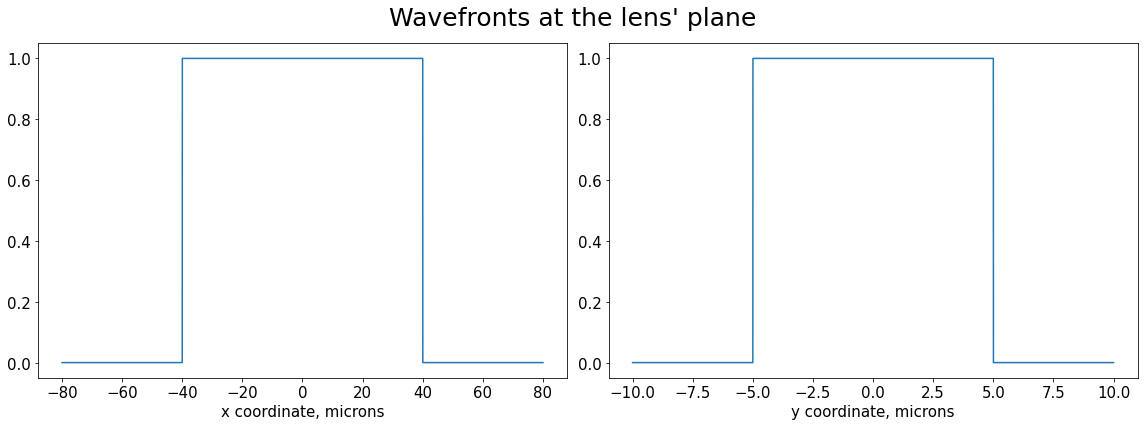

In [9]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx0 * nx_arr, np.abs(lens_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dy0 * ny_arr, np.abs(lens_wfy))
axes[1].set_xlabel('y coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the lens' plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/lens_wf.pdf')

In [10]:
dx1, dy1 = dx0 * defocus / focus, dy0
z01 = focus + defocus
%time defoc_wfx = rsc_wp(lens_wfx, dx0, dx1, z01, wl, num_threads=1)
%time defoc_wfy = rsc_wp(lens_wfy, dy0, dy1, z01, wl, num_threads=12)

CPU times: user 107 ms, sys: 3.08 ms, total: 110 ms
Wall time: 109 ms
CPU times: user 12.6 ms, sys: 0 ns, total: 12.6 ms
Wall time: 12.5 ms


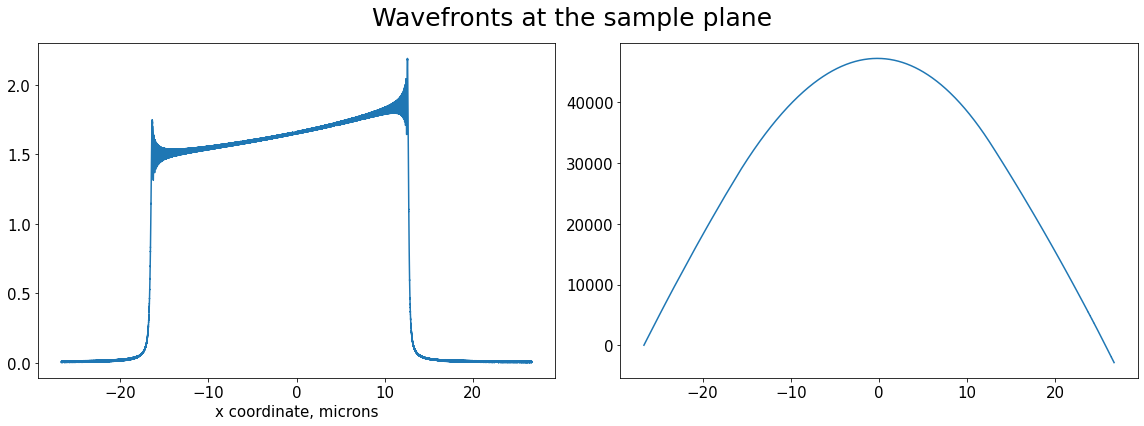

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx1 * nx_arr, np.abs(defoc_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dx1 * nx_arr, np.unwrap(np.angle(defoc_wfx)))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the sample plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/sample_wf.pdf')

In [12]:
x0, x1 = params.beam_span(defocus)
x1 += step_size * n_frames
bar_pos = bar_positions(x0 + offset, x1 - offset, bar_size, bar_rnd, 0)

In [13]:
smp_pos = params.sample_positions()
x_arr = dx1 * nx_arr + smp_pos[:, None]
%time b_tr = barcode_profile(x_arr, bar_pos, 0.3, 0.1, params.bar_sigma, 1)
smp_wfx = defoc_wfx * b_tr

CPU times: user 6.6 s, sys: 70 ms, total: 6.67 s
Wall time: 6.67 s


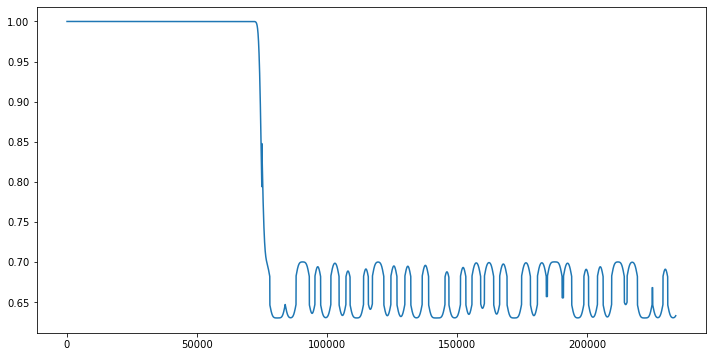

In [14]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.abs(b_tr[0]))
plt.show()

In [17]:
dx2, dy2 = fs_size * pix_size / n_x, ss_size * pix_size / n_y
%time det_wfx = fraunhofer_wp(smp_wfx, dx1, dx2, det_dist, wl, num_threads=64)
%time det_wfy = fraunhofer_wp(defoc_wfy, dy1, dy2, det_dist, wl, num_threads=64)
print(smp_wfx.shape, det_wfx.shape)

CPU times: user 32.5 s, sys: 633 ms, total: 33.1 s
Wall time: 1.01 s
CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 10.5 ms
(200, 234110) (200, 234110)


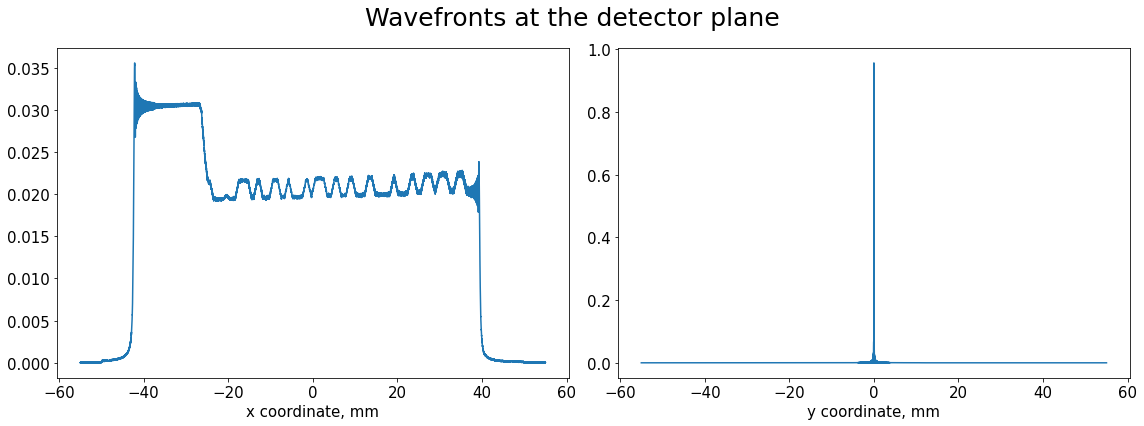

In [18]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.abs(det_wfx[2]))
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.abs(det_wfy))
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_wf.pdf')

In [22]:
sc_x = params.source_curve(defocus + det_dist, dx2)
sc_y = params.source_curve(defocus + det_dist, dy2)
pfx = np.sqrt(p0) / ap_x * np.abs(det_wfx)**2
pfy = np.sqrt(p0) / ap_y * np.abs(det_wfy)**2
print(pfx.shape, sc_x.shape)
%time det_ix = fft_convolve(pfx, sc_x, num_threads=32)
%time det_iy = fft_convolve(pfy, sc_y, num_threads=32)
# print(det_ix.shape, det_iy.shape)

(200, 234110) (2043,)
CPU times: user 1.98 s, sys: 129 ms, total: 2.11 s
Wall time: 176 ms
CPU times: user 863 µs, sys: 0 ns, total: 863 µs
Wall time: 820 µs


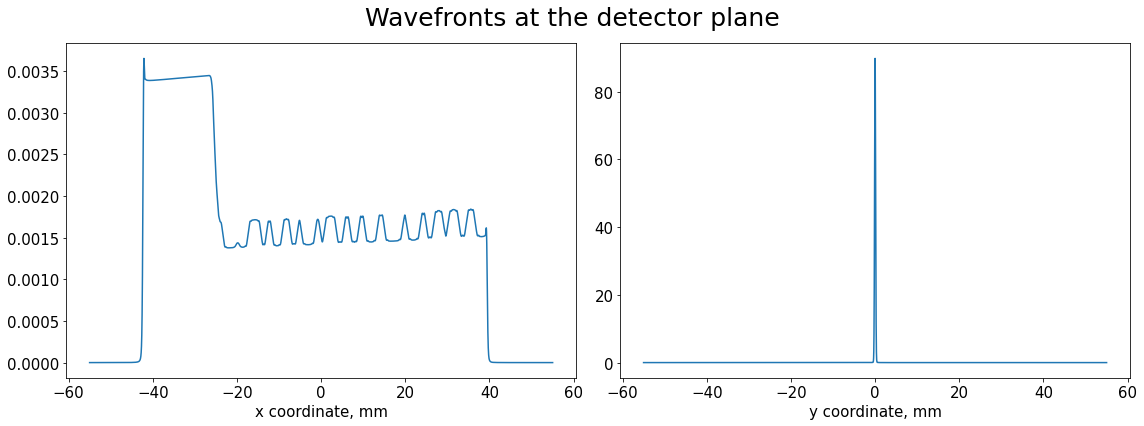

In [23]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.sqrt(p0) / ap_x * det_ix[0] * dx2)
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.sqrt(p0) / ap_y * det_iy * dy2)
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_int.pdf')

In [26]:
wfx = np.ones(fs_size)
wfy = np.ones(ss_size)
%time frames = make_frames(det_ix, det_iy, wfx, wfy, dx2, dy2, -1, 16)
%time wfield = make_whitefield(frames, np.ones(frames.shape, dtype=bool), 0, 16)
frames.shape, wfield.shape

CPU times: user 5.4 s, sys: 800 ms, total: 6.2 s
Wall time: 442 ms
CPU times: user 14.5 s, sys: 63.5 ms, total: 14.5 s
Wall time: 1.09 s


((200, 2000, 2000), (2000, 2000))

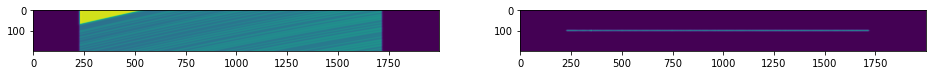

In [27]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(frames.sum(axis=1))
axes[1].imshow(wfield[(ss_size // 2 - 100):(ss_size // 2 + 100), :])
plt.show()

In [19]:
dir_path = 'results/test'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

In [20]:
dir_path = 'results/test_ideal'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

# Prototyping

In [3]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.18,
                           bulk_atn=0.15, rnd_dev=0.7, p0=5e4, th_s=1.5e-4,
                           n_frames=200, defocus=40, alpha=0.04, ab_cnt=0.7,
                           step_size=0.15, step_rnd=0.8, seed=8457259)
st_conv = st_sim.converter()
sim_obj = st_sim.STSim(params, backend='numpy')
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

In [5]:
grad, sweep = data.defocus_sweep(np.linspace(20e-6, 100e-6, 20))

Generating defocus sweep:   0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
st_obj = data.get_st()

st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=8., ls_pm=2.5, blur=6, verbose=True, n_iter=30)

   0%            Iteration 0 / 30 [00:00<?, ?it/s]

Initial MSE = 0.219927, Initial ls_ri = 8.00


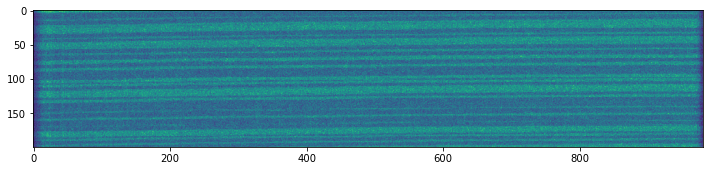

In [29]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

In [30]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'bar_positions', 'barcode_profile', 'fft_convolve', 'fraunhofer_wp', 'gaussian_filter', 'gaussian_gradient_magnitude', 'gaussian_kernel', 'gf', 'ggm', 'init_fftw', 'make_frames', 'make_whitefield', 'mll_profile', 'next_fast_len', 'np', 'rsc_wp']


In [31]:
params = st_sim.parameters(bar_size=0.25, bar_sigma=0.18, bar_atn=0.22,
                           bulk_atn=0.15, bar_rnd=0.7, p0 = 5e4, th_s=8e-5,
                           n_frames=200, defocus=30, alpha=0.03,
                           ab_cnt=0.7)

bar_pos = params.bar_positions(params.focus + params.defocus)
st_conv = st_sim.converter()

In [43]:
sim_obj = st_sim.STSim(params=params, backend='numpy')
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

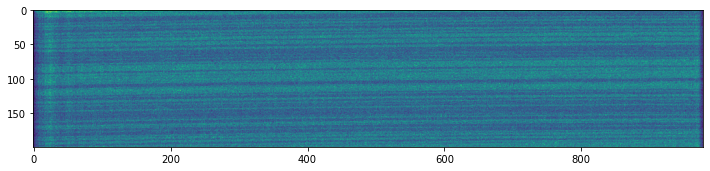

In [44]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

In [45]:
sw_fs=10
sw_ss=0
ls_ri=8.
ls_pm=2.5
blur=6
n_iter=10
f_tol=1e-6
momentum=0.
learning_rate=1e1
gstep=.1

st_obj = data.get_st(num_threads=32)

velocity = 0.0
obj = st_obj.update_reference(ls_ri=ls_ri)
obj.update_errors.inplace_update()
extra = {'errors': [obj.error_frame.mean()],
         'lss_ri': [ls_ri]}
print('Initial MSE = {:.6f}, Initial ls_ri = {:.2f}'.format(extra['errors'][-1],
                                                            extra['lss_ri'][-1]))
for it in range(1, n_iter + 1):
    # Update pixel_map
    new_obj = obj.update_pixel_map(ls_pm=ls_pm, sw_fs=sw_fs, sw_ss=sw_ss)
    obj.pixel_map += gaussian_filter(new_obj.pixel_map - obj.pixel_map,
                                     (0, blur, blur), mode='nearest',
                                     num_threads=st_obj.num_threads)

    # Update ls_ri
    grad = (obj.mse_total(ls_ri + gstep) - extra['errors'][-1]) / gstep
    velocity = np.clip(momentum * velocity - learning_rate * grad,
                       -0.75 * ls_ri, 0.75 * ls_ri)
    ls_ri += velocity
    extra['lss_ri'].append(ls_ri)

    # Update reference_image
    obj.update_reference.inplace_update(ls_ri=ls_ri)
    obj.update_errors.inplace_update()
    extra['errors'].append(obj.error_frame.mean())
    print('Iteration No. {:d}: Total MSE = {:.6f}, ls_ri = {:.2f}'.format(it, extra['errors'][-1],
                                                                          extra['lss_ri'][-1]))

Initial MSE = 0.349431, Initial ls_ri = 8.00
Iteration No. 1: Total MSE = 0.316340, ls_ri = 10.46
Iteration No. 2: Total MSE = 0.281058, ls_ri = 13.35
Iteration No. 3: Total MSE = 0.246875, ls_ri = 16.38
Iteration No. 4: Total MSE = 0.219866, ls_ri = 18.99
Iteration No. 5: Total MSE = 0.199460, ls_ri = 21.06
Iteration No. 6: Total MSE = 0.187906, ls_ri = 22.29
Iteration No. 7: Total MSE = 0.182527, ls_ri = 22.84
Iteration No. 8: Total MSE = 0.179597, ls_ri = 23.08
Iteration No. 9: Total MSE = 0.178431, ls_ri = 23.20
Iteration No. 10: Total MSE = 0.177583, ls_ri = 23.28


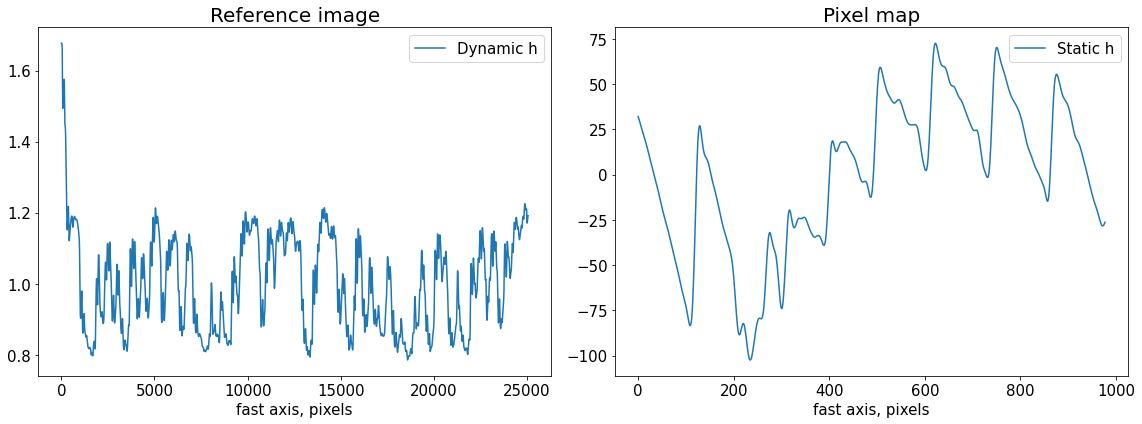

In [46]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(obj.reference_image[0], label='Dynamic h')
axes[1].plot((obj.pixel_map - st_obj.pixel_map)[1, 0] - 
             (obj.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Static h')
axes[0].set_title('Reference image', fontsize=20)
axes[1].set_title('Pixel map', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('fast axis, pixels', fontsize=15)
plt.tight_layout()
plt.show()

In [41]:
st_obj = data.get_st(num_threads=16)
st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=8., ls_pm=2.5, blur=6, verbose=True, n_iter=30)

Initial MSE = 0.440567, Initial ls_ri = 8.00
Iteration No. 1: Total MSE = 0.400667, ls_ri = 10.88
Iteration No. 2: Total MSE = 0.351141, ls_ri = 14.91
Iteration No. 3: Total MSE = 0.309532, ls_ri = 18.93
Iteration No. 4: Total MSE = 0.283405, ls_ri = 21.69
Iteration No. 5: Total MSE = 0.269093, ls_ri = 23.24
Iteration No. 6: Total MSE = 0.260826, ls_ri = 24.06
Iteration No. 7: Total MSE = 0.256253, ls_ri = 24.50
Iteration No. 8: Total MSE = 0.253984, ls_ri = 24.78
Iteration No. 9: Total MSE = 0.250753, ls_ri = 25.04
Iteration No. 10: Total MSE = 0.248626, ls_ri = 25.29
Iteration No. 11: Total MSE = 0.245684, ls_ri = 25.53
Iteration No. 12: Total MSE = 0.243465, ls_ri = 25.80
Iteration No. 13: Total MSE = 0.242260, ls_ri = 25.93
Iteration No. 14: Total MSE = 0.240375, ls_ri = 26.16
Iteration No. 15: Total MSE = 0.239756, ls_ri = 26.21
Iteration No. 16: Total MSE = 0.239550, ls_ri = 26.19
Iteration No. 17: Total MSE = 0.239581, ls_ri = 26.14


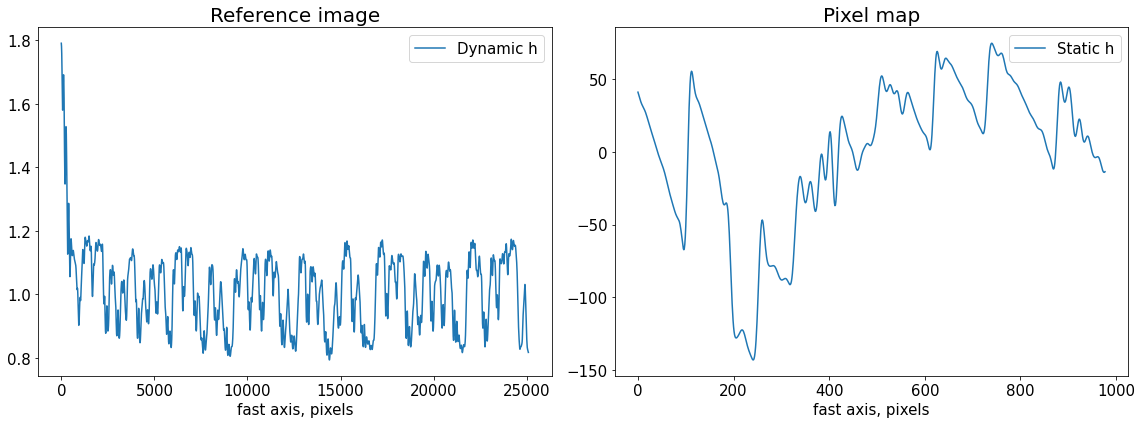

In [42]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0], label='Dynamic h')
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0] - 
             (st_res.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Static h')
axes[0].set_title('Reference image', fontsize=20)
axes[1].set_title('Pixel map', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('fast axis, pixels', fontsize=15)
plt.tight_layout()
plt.show()

In [27]:
data = data.update_phase(st_res)
fit_obj = data.get_fit()
fit_obj.defocus = np.abs(fit_obj.defocus)
fit = fit_obj.fit()
ph_fit = fit_obj.fit_phase()

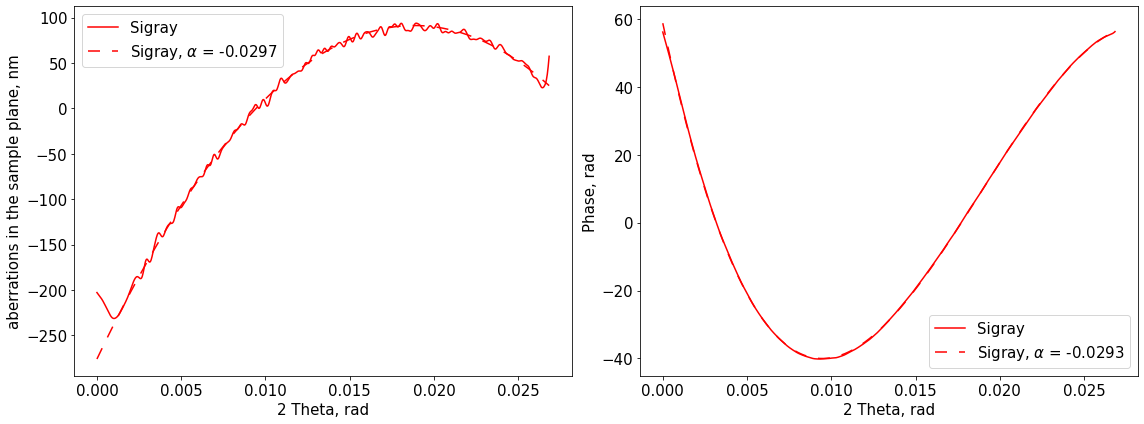

In [28]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.pixel_aberrations * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label='Sigray', c='r')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.model(fit['fit']) * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[0].set_ylabel('aberrations in the sample plane, nm', fontsize=15)
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.phase, label='Sigray', c='r')
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap, fit_obj.model(ph_fit['ph_fit']), 
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(ph_fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[1].set_ylabel('Phase, rad', fontsize=15)
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [10]:
loader = rst.loader()
data = loader.load('results/exp/diatom.cxi', roi=(70, 420, 50, 455), good_frames=np.arange(1, 121))
data = data.update_mask(method='perc-bad', pmin=0.05, pmax=99.998)

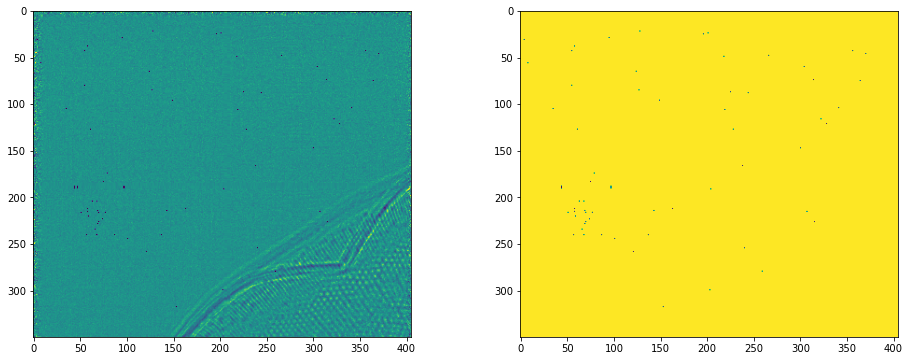

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(np.where(data.get('mask')[0],
                        data.get('data')[0] / data.get('whitefield'),
                        0), vmin=0.5, vmax=1.5)
axes[1].imshow(data.get('mask')[0], vmin=0, vmax=1)
plt.show()

In [12]:
st_obj = data.get_st()
st_obj = st_obj.update_reference(ls_ri=1.1, sw_ss=0, sw_fs=0)

In [14]:
st_obj = data.get_st()
st_rgd = st_obj.iter_update_gd(ls_ri=1.1, ls_pm=1.5, sw_fs=2, sw_ss=2, n_iter=4,
                               verbose=True, learning_rate=0.1)

Initial MSE = 0.874955, Initial ls_ri = 1.10
Iteration No. 1: Total MSE = 0.662130, ls_ri = 1.30
Iteration No. 2: Total MSE = 0.487592, ls_ri = 1.47
Iteration No. 3: Total MSE = 0.446233, ls_ri = 1.52
Iteration No. 4: Total MSE = 0.429475, ls_ri = 1.55


In [16]:
data.data.shape, data.mask.shape

((121, 516, 1556), (121, 516, 1556))

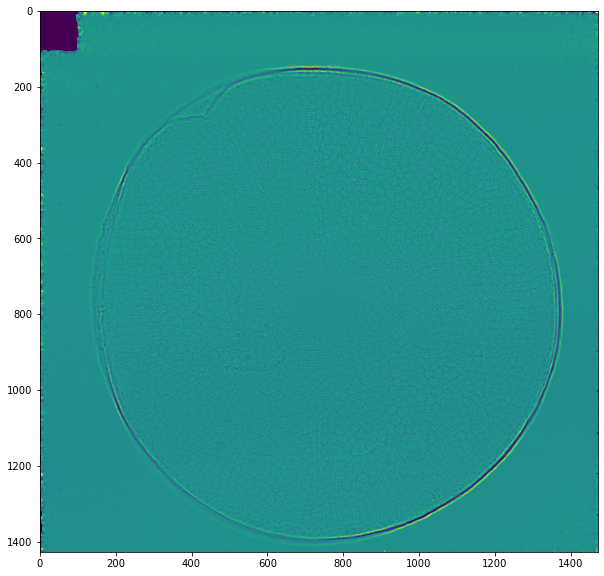

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(st_obj.reference_image, vmin=0.7, vmax=1.3)
ax.imshow(st_rgd.reference_image, vmin=0.7, vmax=1.3)
plt.show()

# Experimental results

In [5]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1100), 2165: (0, 1, 430, 1140),
            2188: (0, 1, 365, 1155), 2202: (0, 1, 275, 1100), 2274: (0, 1, 430, 1140), 2291: (0, 1, 430, 1140),
            2311: (0, 1, 440, 1220), 2312: (0, 1, 440, 1220), 2313: (0, 1, 430, 1220), 2557: (0, 1, 150, 1000),
            2924: (0, 1, 250, 1200), 2934: (0, 1, 320, 1240)}

scan_num = 2934
data_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/Processed/2021/Scan_{scan_num:d}/Scan_{scan_num:d}.cxi'
loader = rst.cxi_loader()
data = loader.load(data_path.format(scan_num), roi=roi_dict[scan_num])
data = data.make_whitefield()

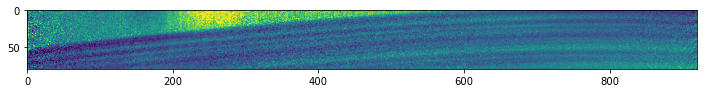

In [6]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0] / data.get('whitefield'), vmin=0.5, vmax=1.9)
# ax.imshow(np.where(data.whitefield, data.data[:, 0] / data.whitefield, 0), vmin=0.5, vmax=1.5)
# ax.imshow(whitefield[:, 0, data.roi[2]:data.roi[3]])
plt.show()

Generating defocus sweep:   0%|          | 0/50 [00:00<?, ?it/s]

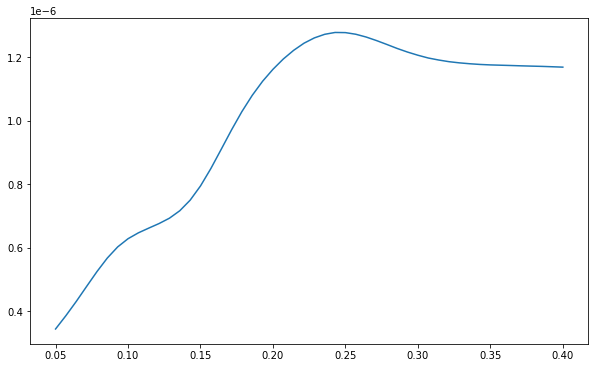

In [7]:
defoci = np.linspace(5e-5, 4e-4, 50)
ds_scan = data.defocus_sweep(defoci, ls_ri=30, return_sweep=False)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(defoci * 1e3, ds_scan)
plt.show()

In [8]:
data = data.update_defocus(defocus_fs=defoci[np.argmax(ds_scan)])

st_obj = data.get_st()

st_rgd = st_obj.iter_update_gd(ls_ri=5., ls_pm=3., blur=12., sw_fs=8, n_iter=150, verbose=True)

   0%            Iteration 0 / 500 [00:00<?, ?it/s]

Initial MSE = 0.599621, Initial ls_ri = 5.00


In [9]:
data = data.update_phase(st_rgd)
fit_obj = data.get_fit(center=1500)

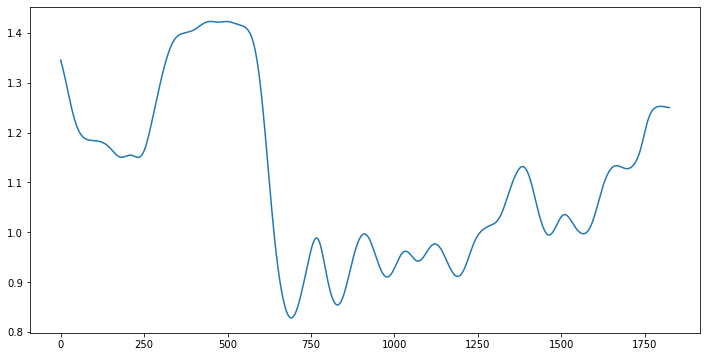

In [10]:
%matplotlib inline
fig, axes = plt.subplots(figsize=(12, 6))
axes.plot(st_rgd.reference_image[0])
plt.show()

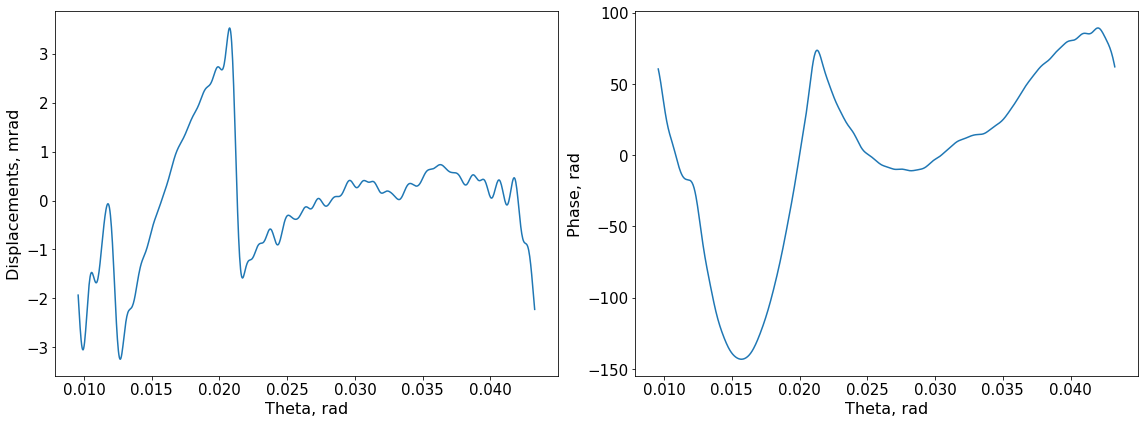

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_obj.pix_ap * fit_obj.get('pixels'), fit_obj.pix_ap * fit_obj.get('pixel_aberrations') * 1e3)
axes[0].set_ylabel('Displacements, mrad', fontsize=16)
axes[1].plot(fit_obj.pix_ap * fit_obj.get('pixels'), fit_obj.get('phase'))
axes[1].set_ylabel('Phase, rad', fontsize=16)
for ax in axes:
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Theta, rad', fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1100), 2165: (0, 1, 430, 1140),
            2188: (0, 1, 365, 1155), 2202: (0, 1, 275, 1100), 2274: (0, 1, 430, 1140), 2291: (0, 1, 430, 1140),
            2311: (0, 1, 440, 1220), 2312: (0, 1, 440, 1220), 2313: (0, 1, 430, 1220), 2557: (0, 1, 150, 1000),
            2924: (0, 1, 250, 1200), 2934: (0, 1, 320, 1240), 2936: (0, 1, 50, 1250)}

scan_num = 2936
data_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/Processed/2021/Scan_{scan_num:d}/Scan_{scan_num:d}.cxi'
loader = rst.cxi_loader()
data = loader.load(data_path.format(scan_num), roi=roi_dict[scan_num])
data = data.make_whitefield()

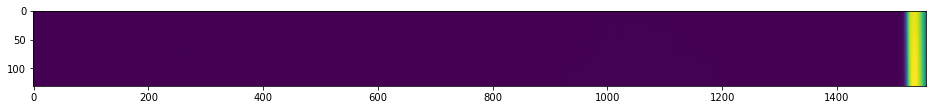

In [13]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16, 6))
# ax.imshow(data.get('data')[:, 0] / data.get('whitefield'), vmin=0.5, vmax=1.5)
# ax.imshow(np.where(data.whitefield, data.data[:, 0] / data.whitefield, 0), vmin=0.5, vmax=1.5)
ax.imshow(data.data[:, 0])
plt.show()

Generating defocus sweep:   0%|          | 0/50 [00:00<?, ?it/s]

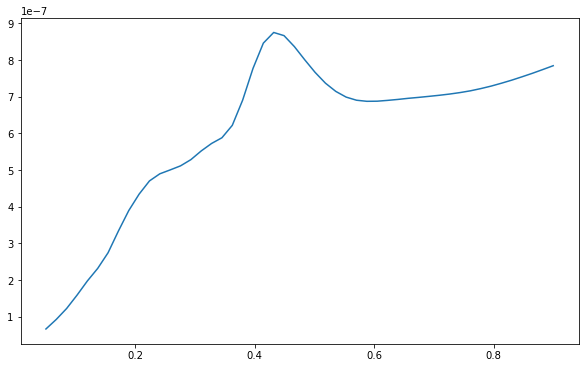

In [14]:
defoci = np.linspace(5e-5, 9e-4, 50)
ds_scan = data.defocus_sweep(defoci, ls_ri=30, return_sweep=False)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(defoci * 1e3, ds_scan)
plt.show()

In [25]:
data = data.update_defocus(defocus_fs=defoci[np.argmax(ds_scan)])

st_obj = data.get_st()

st_rgd = st_obj.iter_update_gd(ls_ri=8., ls_pm=8., blur=12., sw_fs=20, n_iter=20, verbose=True)

   0%            Iteration 0 / 20 [00:00<?, ?it/s]

Initial MSE = 0.247598, Initial ls_ri = 8.00


In [26]:
data = data.update_phase(st_rgd)
fit_obj = data.get_fit(center=1550)

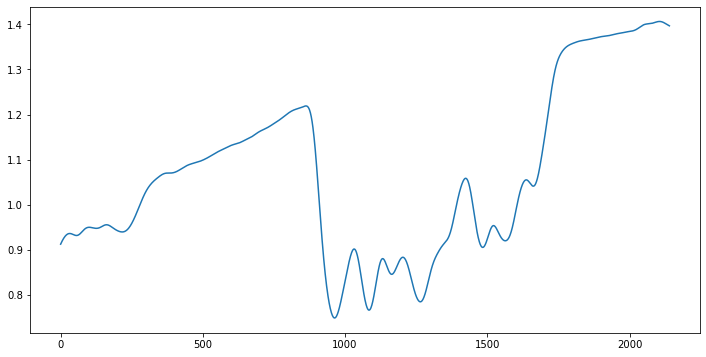

In [27]:
%matplotlib inline
fig, axes = plt.subplots(figsize=(12, 6))
axes.plot(st_rgd.reference_image[0])
plt.show()

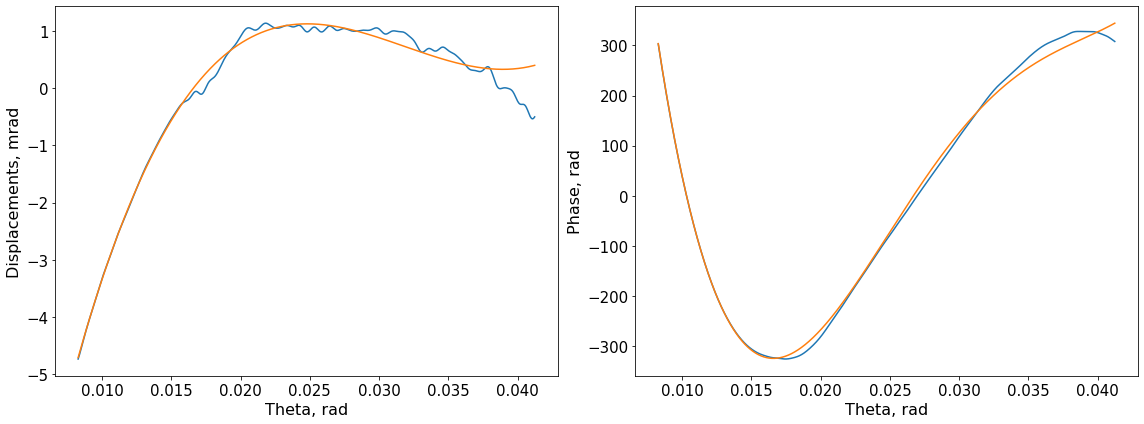

In [28]:
%matplotlib inline
fit = fit_obj.fit(max_order=3)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_obj.pix_ap * fit_obj.get('pixels'), fit_obj.pix_ap * fit_obj.get('pixel_aberrations') * 1e3)
axes[0].plot(fit_obj.pix_ap * fit_obj.get('pixels'), 
             fit_obj.model(fit['fit']) * fit_obj.pix_ap * 1e3)
axes[0].set_ylabel('Displacements, mrad', fontsize=16)
axes[1].plot(fit_obj.pix_ap * fit_obj.get('pixels'), fit_obj.get('phase'))
axes[1].plot(fit_obj.pix_ap * fit_obj.get('pixels'), 
             fit_obj.model(fit['ph_fit']))
axes[1].set_ylabel('Phase, rad', fontsize=16)
for ax in axes:
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Theta, rad', fontsize=16)
plt.tight_layout()
plt.show()

In [29]:
print(fit['ph_fit'][-5] / fit_obj.pix_ap**4 * 1e-12)
print(fit['ph_fit'][-4] / fit_obj.pix_ap**3 * 1e-9)

0.005402651066108143
-0.68892116345897


In [9]:
data_path = 'results/exp/scan_81763.cxi'
loader = rst.loader()
data_nsls = loader.load(data_path, roi=(0, 300, 200, 519))
data_nsls = data_nsls.update_mask(method='perc-bad', percentile=99.995)

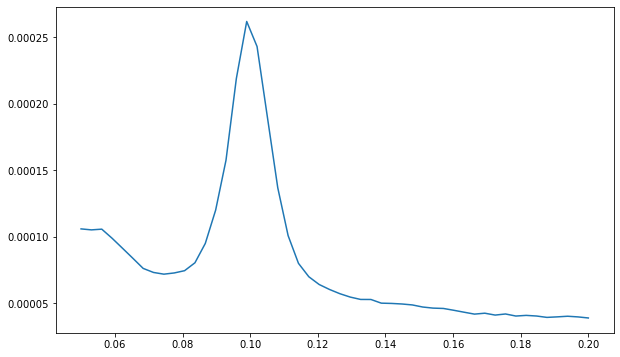

In [198]:
df_nsls = np.linspace(5e-5, 2e-4, 50)
dss_nsls = data_nsls.defocus_sweep(df_nsls, ls_ri=1.1, return_sweep=False)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(defoci * 1e3, ds_scan)
plt.show()

In [328]:
data.wavelength

array(7.09291753e-11)

In [295]:
data_nsls = data_nsls.update_defocus(defocus_fs=df_nsls[np.argmax(dss_nsls)])

st_obj_nsls = data_nsls.get_st()
st_obj_nsls = st_obj_nsls.update_reference(sw_ss=0, sw_fs=0, ls_ri=1.5)

st_rgd_nsls = st_obj_nsls.iter_update_gd(ls_ri=1.1, ls_pm=1.1, sw_fs=3, sw_ss=3, n_iter=20, verbose=True,
                                         learning_rate=0.1)

data_nsls = data_nsls.update_phase(st_rgd_nsls)

Initial MSE = 0.766755, Initial ls_ri = 1.10
Iteration No. 1: Total MSE = 0.553753, ls_ri = 1.30
Iteration No. 2: Total MSE = 0.445012, ls_ri = 1.41
Iteration No. 3: Total MSE = 0.389979, ls_ri = 1.49
Iteration No. 4: Total MSE = 0.433399, ls_ri = 1.47


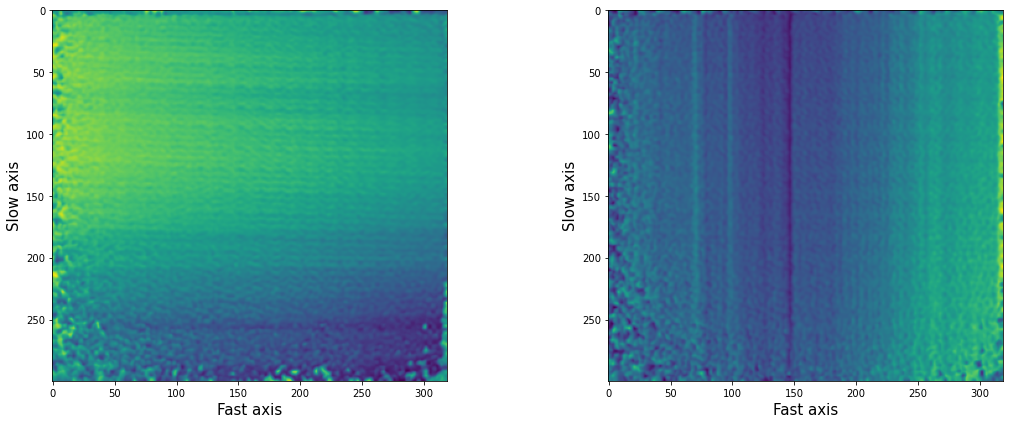

In [327]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0])
axes[1].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[1])
for ax in axes:
    ax.set_xlabel('Fast axis', fontsize=15)
    ax.set_ylabel('Slow axis', fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('nsls_pix_aberrations.pdf')

In [305]:
thetas = np.arange(10, 230) * data_nsls.y_pixel_size / data_nsls.distance
dev = np.interp(thetas, (fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
                   fit_obj.pixel_aberrations * data.defocus_fs * data.x_pixel_size / data.distance)

In [312]:
pix_shift = 5

# dev_ss = np.mean((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0, :, 100:], axis=1, keepdims=True)
dev_ss = (st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0, :, [280]].T
dev_fs = np.zeros(dev_ss.shape, dtype=np.float64)
d_ab = (dev - dev_ss[10 + pix_shift:230 + pix_shift, 0] * \
        data_nsls.defocus_ss * data_nsls.y_pixel_size / data_nsls.distance).mean()
dev_ss += d_ab / (data_nsls.defocus_ss * data_nsls.y_pixel_size / data_nsls.distance)

phase = ct_integrate(data_nsls.y_pixel_size**2 * dev_ss * data_nsls.defocus_ss / data_nsls.wavelength,
                     data_nsls.x_pixel_size**2 * dev_fs * data_nsls.defocus_fs / data_nsls.wavelength) \
        * 2 * np.pi / data_nsls.distance**2
fit_obj_nsls = rst.AberrationsFit(defocus=data_nsls.defocus_ss, distance=data_nsls.distance,
                                  phase=phase[:, 0], pixels=np.arange(0, phase.size) - pix_shift,
                                  pixel_aberrations=dev_ss[:, 0], pixel_size=data_nsls.y_pixel_size,
                                  roi=(0, phase.size), wavelength=data_nsls.wavelength)
dev_ss.shape

(300, 1)

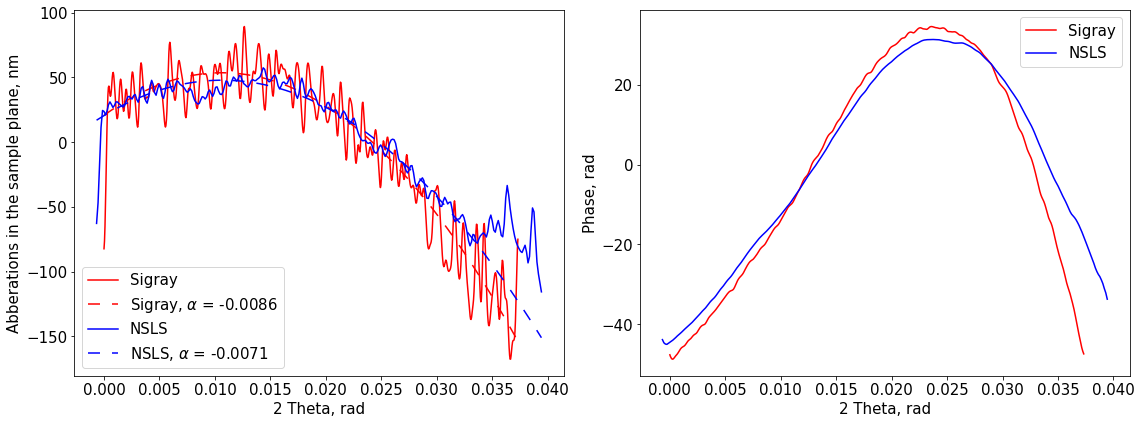

In [323]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fit_nsls = fit_obj_nsls.crop_data([10, 240]).fit()
fit = fit_obj.crop_data([10, 650]).fit(loss='linear')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.pixel_aberrations * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label='Sigray', c='r')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.model(fit['fit']) * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[0].set_ylabel('aberrations in the sample plane, nm', fontsize=15)
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.phase, label='Sigray', c='r')
axes[1].set_ylabel('Phase, rad', fontsize=15)
axes[0].plot(fit_obj_nsls.pixels * fit_obj_nsls.pix_ap,
             fit_obj_nsls.pixel_aberrations * fit_obj_nsls.pix_ap * fit_obj_nsls.defocus * 1e9,
             label='NSLS', c='b')
axes[0].plot(fit_obj_nsls.pixels * fit_obj_nsls.pix_ap,
             fit_obj_nsls.model(fit_nsls['fit']) * fit_obj_nsls.pix_ap * fit_obj_nsls.defocus * 1e9,
             label=r'NSLS, $\alpha$ = ' + '{:.4f}'.format(fit_nsls['alpha']),
             c='b', linestyle='dashed', dashes=(8, 8))
axes[1].plot(fit_obj_nsls.pixels * fit_obj_nsls.pix_ap,
             fit_obj_nsls.phase, label='NSLS', c='b')
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
# plt.savefig('figures/nsls_sigray_comp.pdf')
plt.show()